In [10]:
import pandas as pd
import numpy as np
import sys
import anndata
import scanpy as sc
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
import scanpy as sc
import squidpy as sq
lr_df = pd.read_csv('/home/lishiying/data6/SPIDER-paper/spider_local/lrdb/lrpairs.tsv', sep='\t', index_col=0)
lr_df = lr_df[lr_df['species'] == 'Human']
adata = anndata.read_h5ad('../input_datasets/PDAC/PDAC_A/adata.h5ad')

In [12]:
sv_r_genes = pd.read_csv('sv_r_genes.csv', index_col=0)
non_sv_r_genes = pd.read_csv('non_sv_r_genes.csv', index_col=0)

In [13]:
var_exp_df = pd.read_csv('./var_exp_df.csv', index_col=0)
var_exp_df_nsv = pd.read_csv('./var_exp_df_nsv.csv', index_col=0)

Text(0.5, 1.0, 'AUC across datasets with different interaction fraction')

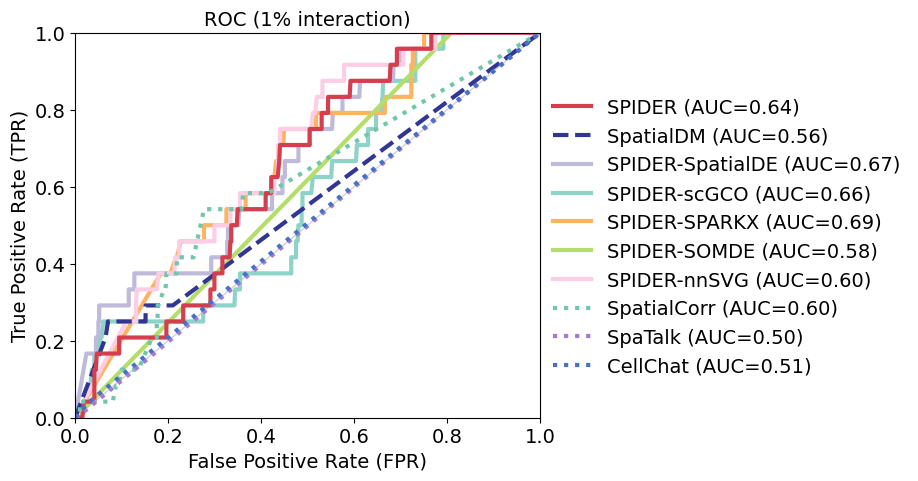

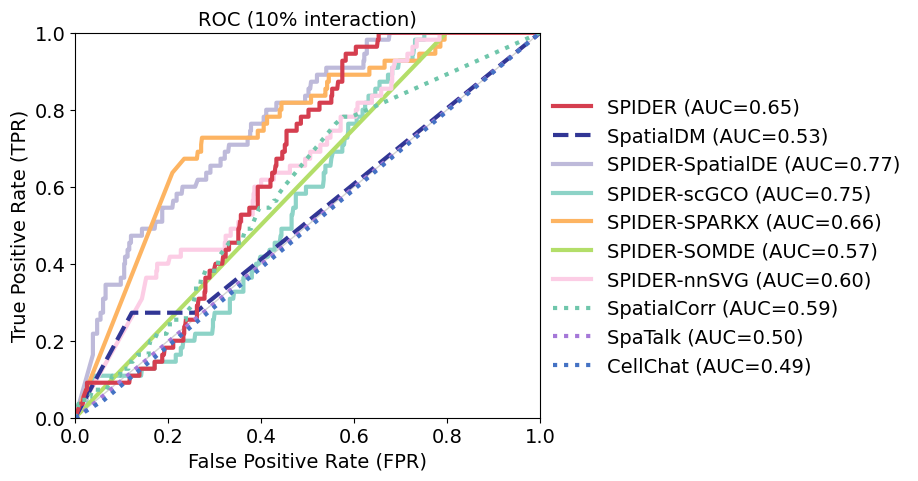

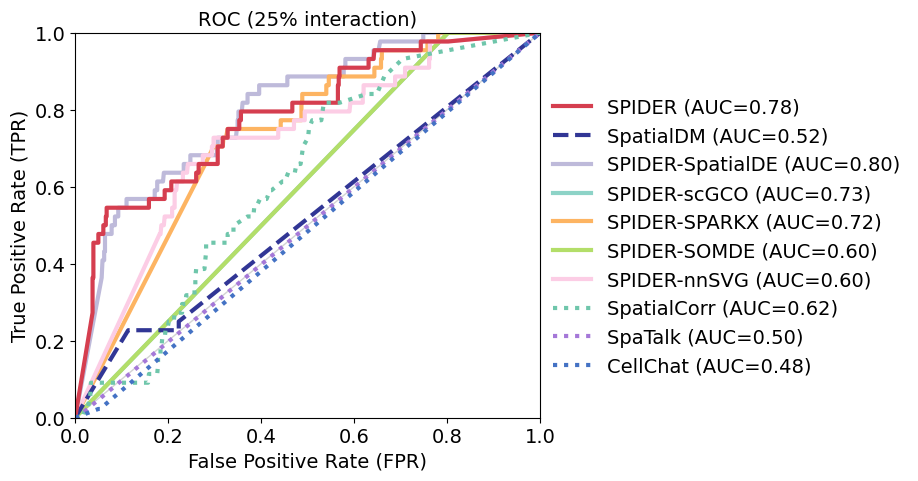

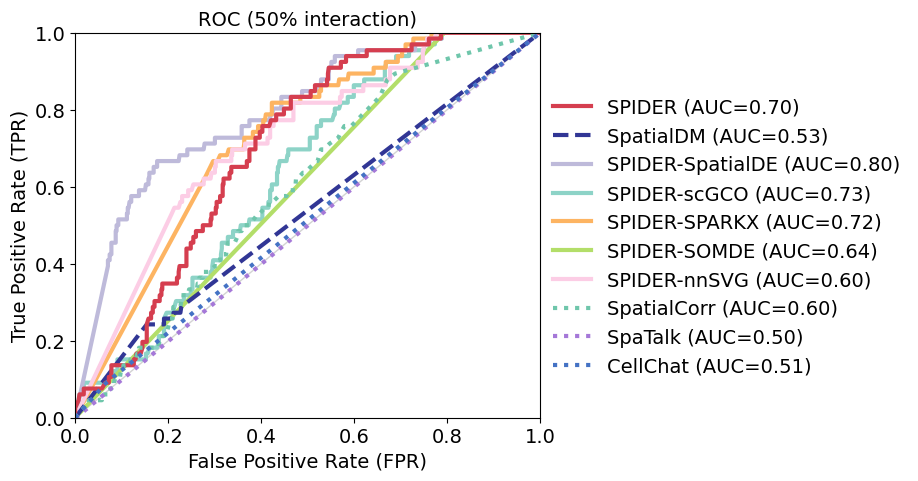

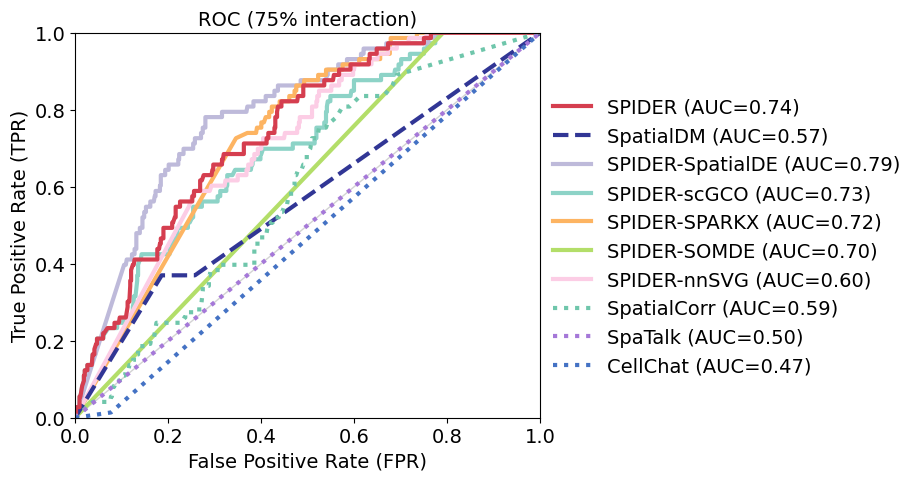

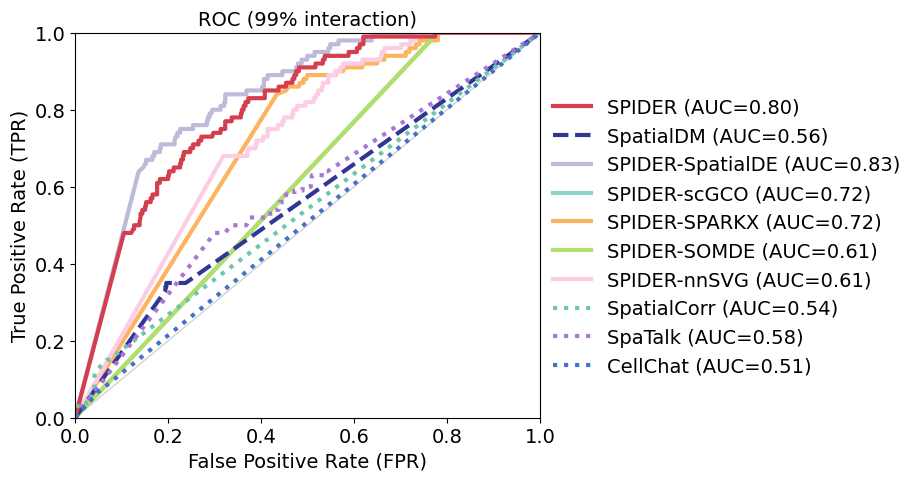

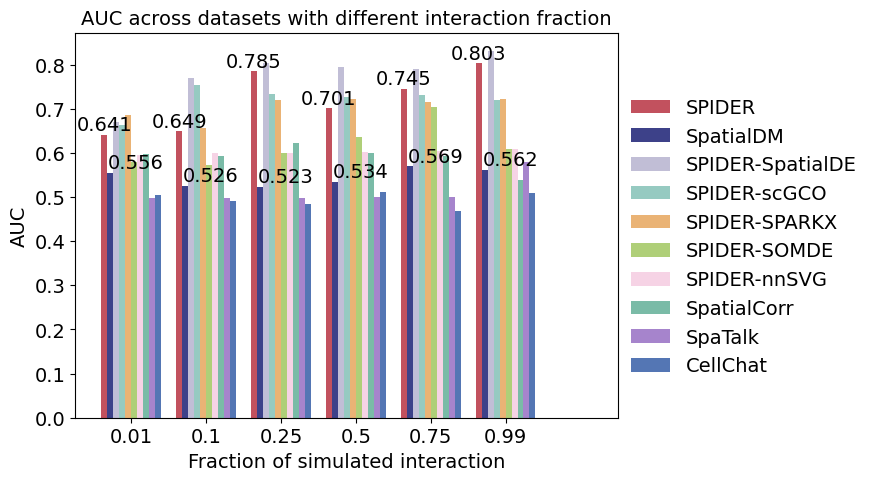

In [14]:
for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
    new_adata_99 = anndata.read_h5ad(f'./adata_{frac}.h5ad')
    lr_from_sv_name = var_exp_df[(var_exp_df['input_int_frac'] == frac)].gene.to_numpy()
    lr_from_nsv_name = var_exp_df_nsv[(var_exp_df_nsv['input_int_frac'] == frac)].gene.to_numpy()
    # for lr in both sv and nsv, drop nsv lrs
    lr_from_nsv_name = lr_from_nsv_name[~np.isin(lr_from_nsv_name, lr_from_sv_name)]
    sp = pd.read_csv(f'./spider_{frac}.csv', index_col=0)[['SOMDE', 'SpatialDE', 'SPARKX', 'nnSVG', 'scGCO']]
    sp['sp'] = sp.max(axis=1)

    dm = pd.read_csv(f'./spatialdm_{frac}.csv', index_col=0).drop_duplicates(subset=['Ligand0', 'Receptor0', 'Receptor1'])
    # dm = dm.drop_duplicates(subset=['Ligand0', 'Receptor0', 'Receptor1'])
    dm_expand = []
    addition = []
    for x in dm.to_numpy():
        l, r1, r2, _, fdr, _ = x
        if r2:
            addition.append([l, r1, fdr])
            addition.append([l, r2, fdr])
        else:
            dm_expand.append([l, r1, fdr])
    dm_expand = pd.DataFrame(dm_expand, columns=['ligand', 'receptor', 'fdr'])
    dm_expand.index = dm_expand['ligand'] + '_' + dm_expand['receptor']

    addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'fdr'])
    addition['lr'] = addition['ligand'] + '_' + addition['receptor']
    addition = addition.loc[addition.groupby('lr')['fdr'].idxmin()][['ligand', 'receptor', 'fdr']]
    addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                            
    dm_expand = pd.concat([dm_expand[['fdr']], addition[~addition.index.isin(dm_expand.index)][['fdr']]])

    spc = pd.read_csv(f'./spc_{frac}.csv', index_col=0)


    spatalk = pd.read_csv(f'./spatalk_{frac}.csv', index_col=0)

    if len(spatalk) != 0:
        spatalk.index = spatalk['ligand'] + '_' + spatalk['receptor']
        spatalk = spatalk.groupby(spatalk['ligand'] + '_' + spatalk['receptor'])['lr_co_ratio_pvalue'].min()
        
    cellchat = pd.read_csv(f'./cellchat_{frac}.csv', index_col=0)

    cellchat = cellchat.groupby(cellchat['ligand'] + '_' + cellchat['receptor'])['pval'].min().reset_index()
    cellchat[['Ligand0', 'Receptor0', 'Receptor1']] = cellchat['index'].str.split('_', expand=True).to_numpy()
    cellchat.set_index('index', inplace=True)
    dm_expand_cellchat = []
    addition = []
    for x in cellchat.to_numpy():
        fdr, l, r1, r2 = x
        if r2:
            addition.append([l, r1, fdr])
            addition.append([l, r2, fdr])
        else:
            dm_expand_cellchat.append([l, r1, fdr])
    dm_expand_cellchat = pd.DataFrame(dm_expand_cellchat, columns=['ligand', 'receptor', 'cellchat'])
    dm_expand_cellchat.index = dm_expand_cellchat['ligand'] + '_' + dm_expand_cellchat['receptor']

    addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'cellchat'])
    addition['lr'] = addition['ligand'] + '_' + addition['receptor']
    addition = addition.loc[addition.groupby('lr')['cellchat'].idxmin()][['ligand', 'receptor', 'cellchat']]
    addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                            
    dm_expand_cellchat = pd.concat([dm_expand_cellchat, addition[~addition.index.isin(dm_expand.index)]])

    if len(spatalk) != 0:
        merged = pd.concat([spc[['spc']], dm_expand, sp, spatalk, dm_expand_cellchat['cellchat']], axis=1).fillna(1)
    else:
        merged = pd.concat([spc[['spc']], dm_expand, sp, dm_expand_cellchat['cellchat']], axis=1).fillna(1)
        merged['lr_co_ratio_pvalue'] = 1
        
    assert len(np.unique(merged.index)) == len(merged)

    lrdf_index = (lr_df['ligand'] + '_' + lr_df['receptor']).to_numpy()

    true_label = []
    for x in merged.index:
        l, r = x.split('_')
        if l in new_adata_99.var_names and r in new_adata_99.var_names:
            if r in non_sv_r_genes.index:
                true_label.append(0)
            elif l in lr_from_nsv_name:
                true_label.append(0)
            # elif l == r:
            #     true_label.append(-1)
            elif x not in lrdf_index:
                true_label.append(0)
            elif l == r:
                true_label.append(0)
            elif x not in lrdf_index:
                true_label.append(0)
            elif l in lr_from_sv_name:
                l_exp = new_adata_99.to_df()[l]
                r_exp = new_adata_99.to_df()[r]
                # get correlation bettwen l_exp and r_exp
                corr = np.corrcoef(l_exp, r_exp)[0, 1]
                if corr <= 0.1:
                    true_label.append(0)
                else:
                    df = var_exp_df.query(f'input_int_frac=={frac}')
                    true_label.append(df.loc[df.gene==l, 'label'].values[0])

            else:
                print(l, r)
                true_label.append(-1)
        else:
            true_label.append(-1)

    merged['label'] = true_label
    merged_sub = merged[merged['label'] != -1]

    arr_x = []
    arr_y = []
    # from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    y_true = merged_sub['label']
    fpr_sp, tpr_sp, thresholds_sp = roc_curve(y_true, 1-merged_sub['sp'])
    fpr_SOMDE, tpr_SOMDE, thresholds_SOMDE = roc_curve(y_true, 1-merged_sub['SOMDE'])
    fpr_SpatialDE, tpr_SpatialDE, thresholds_SpatialDE = roc_curve(y_true, 1-merged_sub['SpatialDE'])
    fpr_scGCO, tpr_scGCO, thresholds_scGCOE = roc_curve(y_true, 1-merged_sub['scGCO'])
    fpr_nnSVG, tpr_nnSVG, thresholds_nnSVG = roc_curve(y_true, 1-merged_sub['nnSVG'])
    fpr_SPARKX, tpr_SPARKX, thresholds_SPARKX = roc_curve(y_true, 1-merged_sub['SPARKX'])
    fpr_dm, tpr_dm, thresholds_dm = roc_curve(y_true, 1-merged_sub['fdr'])
    fpr_spc, tpr_spc, thresholds_spc = roc_curve(y_true, 1-merged_sub['spc'])
    fpr_spatalk, tpr_spatalk, thresholds_spatalk = roc_curve(y_true, 1-merged_sub['lr_co_ratio_pvalue'])
    fpr_cellchat, tpr_cellchat, thresholds_cellchat = roc_curve(y_true, 1-merged_sub['cellchat'])
    roc_auc_SOMDE = auc(fpr_SOMDE, tpr_SOMDE)
    roc_auc_SpatialDE = auc(fpr_SpatialDE, tpr_SpatialDE)
    roc_auc_scGCO = auc(fpr_scGCO, tpr_scGCO)
    roc_auc_nnSVG = auc(fpr_nnSVG, tpr_nnSVG)
    roc_auc_SPARKX = auc(fpr_SPARKX, tpr_SPARKX)
    roc_auc_sp = auc(fpr_sp, tpr_sp)
    roc_auc_dm = auc(fpr_dm, tpr_dm)
    roc_auc_spc = auc(fpr_spc, tpr_spc)
    roc_auc_spatalk = auc(fpr_spatalk, tpr_spatalk)
    roc_auc_cellchat = auc(fpr_cellchat, tpr_cellchat)
    # print(roc_auc)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], color='lightgray', lw=1)
    # Plot the lines
    line1, = plt.plot(fpr_SOMDE, tpr_SOMDE, color='#8dd3c7', lw=3, label=f'SPIDER-SOMDE  (AUC = {roc_auc_SOMDE:.2f})')
    line2, = plt.plot(fpr_SpatialDE, tpr_SpatialDE, color='#BEBADA', lw=3, label=f'SPIDER-SpatialDE  (AUC = {roc_auc_SpatialDE:.2f})')
    line3, = plt.plot(fpr_scGCO, tpr_scGCO, color='#FDB462', lw=3, label=f'SPIDER-scGCO  (AUC = {roc_auc_scGCO:.2f})')
    line4, = plt.plot(fpr_nnSVG, tpr_nnSVG, color='#B3DE69', lw=3, label=f'SPIDER-nnSVG  (AUC = {roc_auc_nnSVG:.2f})')
    line5, = plt.plot(fpr_SPARKX, tpr_SPARKX, color='#FCCDE5', lw=3, label=f'SPIDER-SPARKX  (AUC = {roc_auc_SPARKX:.2f})')
    line6, = plt.plot(fpr_dm, tpr_dm, color='#313695', lw=3, label=f'SpatialDM (AUC = {roc_auc_dm:.2f})', linestyle='--')
    line7, = plt.plot(fpr_sp, tpr_sp, color='#D53E4F', lw=3, label=f'SPIDER (AUC = {roc_auc_sp:.2f})')
    line8, = plt.plot(fpr_spc, tpr_spc, color='#6FC6AB', lw=3, label=f'SpatialCorr (AUC = {roc_auc_spc:.2f})', linestyle=':')
    line9, = plt.plot(fpr_spatalk, tpr_spatalk, color='#A578D8', lw=3, label=f'SpaTalk (AUC = {roc_auc_spatalk:.2f})', linestyle=':')
    line10, = plt.plot(fpr_cellchat, tpr_cellchat, color='#4472C4', lw=3, label=f'CellChat (AUC = {roc_auc_cellchat:.2f})', linestyle=':')

    # Set the x and y limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # Set the x and y labels and the plot title
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'ROC ({int(frac*100)}% interaction)', fontsize=14)

    # Create a custom legend with desired order and font size
    handles = [line7, line6, line2, line1, line3, line4, line5, line8, line9, line10]
    labels = [
        f'SPIDER (AUC={roc_auc_sp:.2f})',
        f'SpatialDM (AUC={roc_auc_dm:.2f})',
        f'SPIDER-SpatialDE (AUC={roc_auc_SpatialDE:.2f})',
        f'SPIDER-scGCO (AUC={roc_auc_scGCO:.2f})',
        f'SPIDER-SPARKX (AUC={roc_auc_SPARKX:.2f})',
        f'SPIDER-SOMDE (AUC={roc_auc_SOMDE:.2f})',
        f'SPIDER-nnSVG (AUC={roc_auc_nnSVG:.2f})',
        f'SpatialCorr (AUC={roc_auc_spc:.2f})',
        f'SpaTalk (AUC={roc_auc_spatalk:.2f})',
        f'CellChat (AUC={roc_auc_cellchat:.2f})'
    ]

    # plt.legend(handles, labels, loc='lower right', fontsize=8)
    plt.legend(handles, labels, bbox_to_anchor=(1.01, 0.85),  loc=2, borderaxespad=0., fontsize=14, frameon=False)

    dic_99 = {
        'SPIDER': roc_auc_sp,
        'SpatialDM': roc_auc_dm,
        'SPIDER-SpatialDE': roc_auc_SpatialDE,
        'SPIDER-scGCO': roc_auc_scGCO,
        'SPIDER-SPARKX': roc_auc_SPARKX,
        'SPIDER-nnSVG': roc_auc_nnSVG,
        'SPIDER-SOMDE': roc_auc_SOMDE,
        'SpatialCorr': roc_auc_spc,
        'SpaTalk': roc_auc_spatalk,
        'CellChat': roc_auc_cellchat
    }
    import json
    # save dic_99 with json
    with open(f'./dic_{frac}.json', 'w') as f:
        json.dump(dic_99, f)
        
df = {}
import json

for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
    # read json ./dic_{frac}.json
    with open(f'./dic_{frac}.json', 'r') as f:
        dic = json.load(f)
    df[str(frac)] = dic
df = pd.DataFrame(df)
df = df.rename_axis('method').reset_index(drop=False).melt(id_vars='method')
df.columns = ['Method', 'Fraction of interaction', 'AUC']
import seaborn as sns
# code for plotting df with seaborn grouped bar plot
plt.figure(figsize=(7, 5))
g = sns.barplot(data=df, x='Fraction of interaction', y='AUC', hue='Method', 
            hue_order=['SPIDER', 'SpatialDM', 'SPIDER-SpatialDE', 'SPIDER-scGCO', 'SPIDER-SPARKX', 'SPIDER-SOMDE', 'SPIDER-nnSVG', 'SpatialCorr', 'SpaTalk', 'CellChat'],
            palette=['#D53E4F', '#313695', '#BEBADA', '#8dd3c7', '#FDB462','#B3DE69', '#FCCDE5', '#6FC6AB', '#A578D8', '#4472C4'],)
count = 0
for p in g.patches:
    if count < 6:
        if False:
        # if count < 2:
            g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. - 0.03, p.get_height()+0.02),
                ha='left', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
        else:
            g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. , p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
    elif count < 12:
        g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. - 0.03, p.get_height()),
                ha='left', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
    count += 1
plt.xlim([-0.75, 6.5])
# plt.ylim([0.4, 0.85])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
plt.legend(bbox_to_anchor=(1.01, 0.85),  loc=2, borderaxespad=0., fontsize=14, frameon=False)
plt.ylabel('AUC', fontsize=14)
plt.xlabel('Fraction of simulated interaction', fontsize=14)
plt.title(f'AUC across datasets with different interaction fraction', fontsize=14)



In [15]:
# for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
#     !cp ../../notebook_spatialdm/spider_{frac}_spatalk/_lrpair.csv ./spatalk_{frac}.csv
#     !cp ../../notebook_spatialdm/spider_{frac}_spatalk/cellchat_lrnet.csv ./cellchat_{frac}.csv

using spatalk result
no spatalk result, using all lrpairs
Using human LR pair dataset.
scoring
using neighbor+sqrt+max
Construct idata with 762 interfaces and 494 LR pairs.
number of interface is less than 1000, skipping abstraction
Added key nnSVG in idata.uns
Added key SOMDE in idata.uns
Added key SpatialDE in idata.uns
Added key SPARKX in idata.uns
Added key scGCO in idata.uns
Added key moranI in idata.uns
Added key gearyC in idata.uns
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
374/494 SVIs identified (threshold=0.01).
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
374/494 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Geary C 

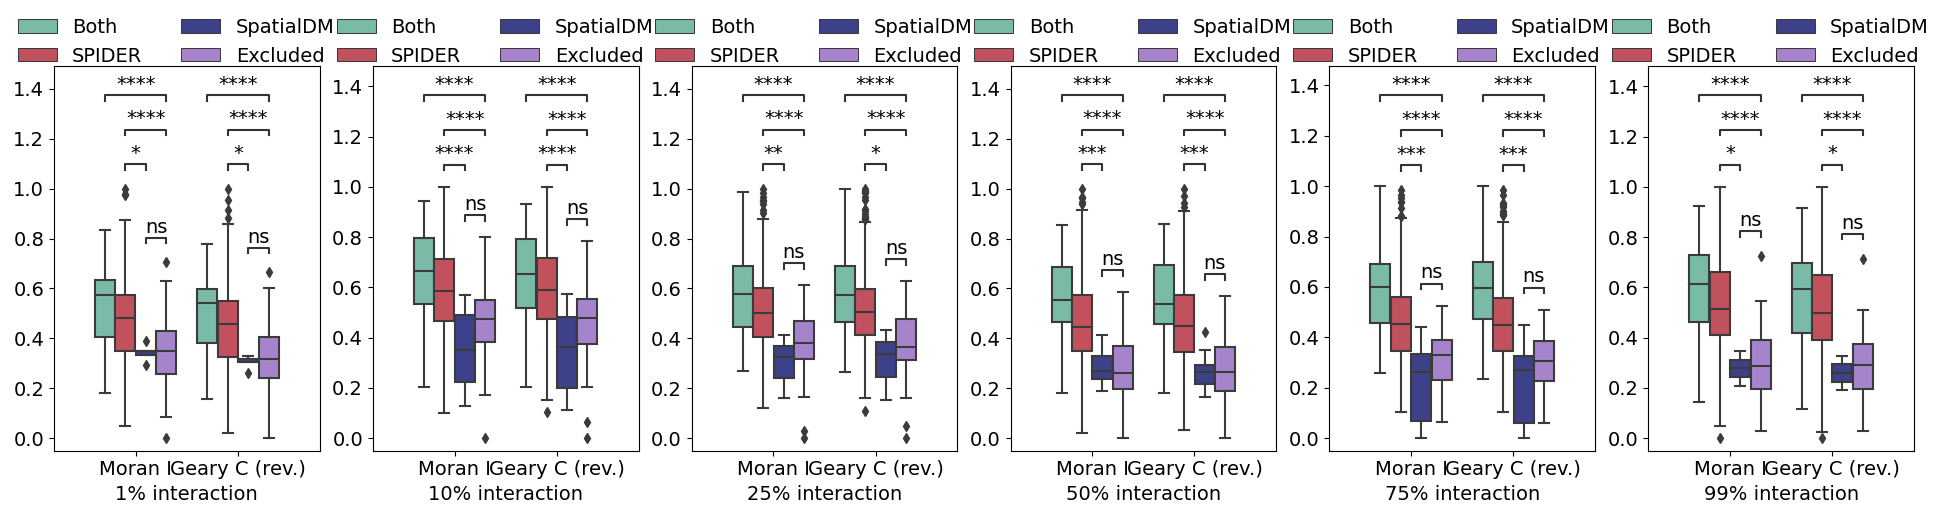

In [16]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(24, 5))
fig_count = 1
for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
    new_adata_99 = anndata.read_h5ad(f'./adata_{frac}.h5ad')

    out_f = f'./spider_{frac}/'

    from spider import SPIDER
    op = SPIDER()
    idata = op.prep(new_adata_99, out_f, R_path, cluster_key='cluster', is_human=True, coord_type='grid', no_spatalk=True, imputation=False)
    idata, meta_idata = op.find_svi(idata, out_f, R_path, alpha=0.3,abstract=False, overwrite=False, n_jobs=1)
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)

    dm = pd.read_csv(f'./spatialdm_{frac}.csv', index_col=0).drop_duplicates(subset=['Ligand0', 'Receptor0', 'Receptor1'])
    dm = dm.query('selected==True')
    dm_expand = []
    addition = []
    for x in dm.to_numpy():
        l, r1, r2, _, fdr, _ = x
        if r2:
            addition.append([l, r1, fdr])
            addition.append([l, r2, fdr])
        else:
            dm_expand.append([l, r1, fdr])
    dm_expand = pd.DataFrame(dm_expand, columns=['ligand', 'receptor', 'fdr'])
    dm_expand.index = dm_expand['ligand'] + '_' + dm_expand['receptor']

    addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'fdr'])
    addition['lr'] = addition['ligand'] + '_' + addition['receptor']
    addition = addition.loc[addition.groupby('lr')['fdr'].idxmin()][['ligand', 'receptor', 'fdr']]
    addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                            
    dm_expand = pd.concat([dm_expand[['fdr']], addition[~addition.index.isin(dm_expand.index)][['fdr']]])
    dm_expand = dm_expand.loc[dm_expand.index.isin(idata.var_names)]
    dm_expand = dm_expand.reset_index().drop_duplicates().set_index('index')

    sdm_unique = dm_expand.loc[(list(set(dm_expand.index) - set(svi_df_strict.index)))].sort_values('fdr').index
    sp_unique = svi_df_strict.loc[(list(set(svi_df_strict.index) - set(dm_expand.index)))].max(axis=1).sort_values().index
    shared = list(set(dm_expand.index) & set(svi_df_strict.index))

    import seaborn as sns
    from statannotations.Annotator import Annotator
    methods = np.array(['moranI', 'gearyC', 'SOMDE', 'nnSVG'])[np.isin(['SOMDE', 'nnSVG', 'gearyC', 'moranI'],list(idata.uns.keys()))]
    print(f'evaluating with {methods}')
    dfs = []
    metrics = []
    for i in methods:
        if i == 'gearyC':
            dfs.append(-idata.uns['gearyC'][['C']])
            metrics.append("Geary C (rev.)")
        elif i == 'moranI':
            dfs.append(idata.uns['moranI'][['I']]),
            metrics.append("Moran I")
    df = pd.concat(dfs, axis=1)
    df.columns=metrics
    normalized_df = (df-df.min())/(df.max()-df.min())
    normalized_df = normalized_df.fillna(0)
    df = normalized_df
    df['Category'] = 'Excluded'
    df.loc[sdm_unique, 'Category'] = 'SpatialDM'
    df.loc[sp_unique, 'Category'] = 'SPIDER'
    df.loc[shared, 'Category'] = 'Both'
    normalized_df = df

    pairs = []
    for i in metrics:
        pairs.append( ((i, 'Both'), (i, 'Excluded')) )
        pairs.append( ((i, 'SPIDER'), (i, 'Excluded')) )
        pairs.append( ((i, 'SpatialDM'), (i, 'Excluded')) )
        pairs.append( ((i, 'SPIDER'), (i, 'SpatialDM')) )


    plt.subplot(1, 6, fig_count)
    fig_count += 1
    normalized_df = normalized_df.melt(id_vars='Category', value_vars=metrics, var_name='Metric')
    ax =sns.boxplot(data=normalized_df,x='Metric',y='value', hue='Category', 
                    palette={'SpatialDM':'#313695', 'SPIDER': '#D53E4F', 'Both': '#6FC6AB', 'Excluded': '#A578D8'}, 
                    width=0.8, hue_order=['Both', 'SPIDER', 'SpatialDM', 'Excluded'])
    ax.legend(loc='upper center',ncol=2, bbox_to_anchor=(0.46, 1.17), frameon=False)
    annot = Annotator(ax, pairs, data=normalized_df, x='Metric',y='value', hue='Category', hue_order=['Both', 'SPIDER', 'SpatialDM', 'Excluded'])
    annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
    annot.apply_and_annotate()
    ax.set_ylabel('')    
    ax.set_xlabel(f'{int(frac*100)}% interaction', fontsize=14)
    # plt.show()

excluding non-simulated LRIs

Text(0.5, 1.0, 'AUC across datasets with different interaction fraction')

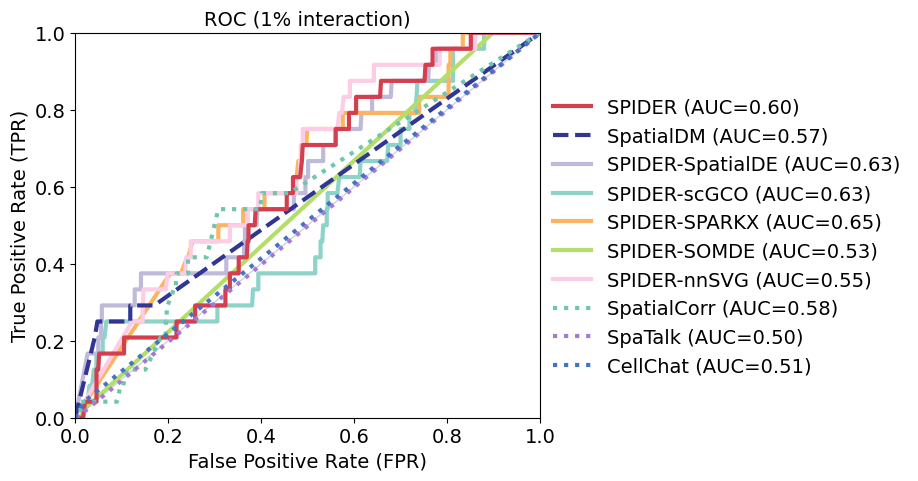

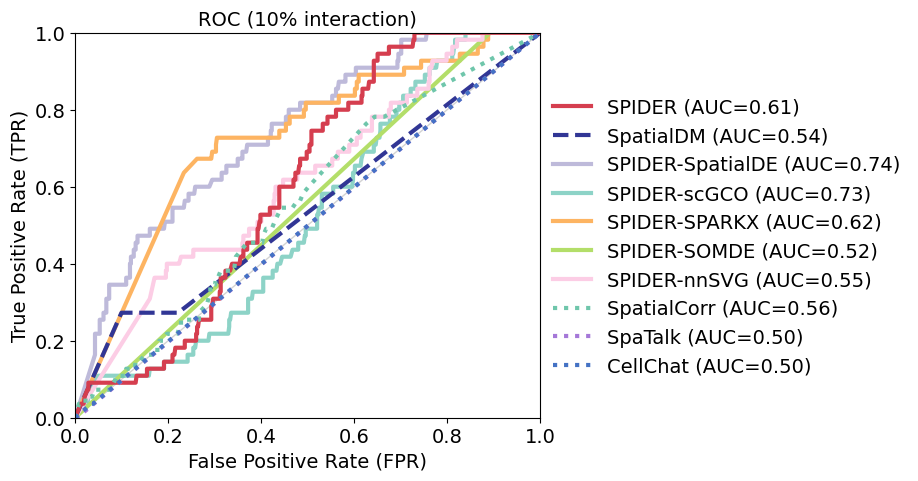

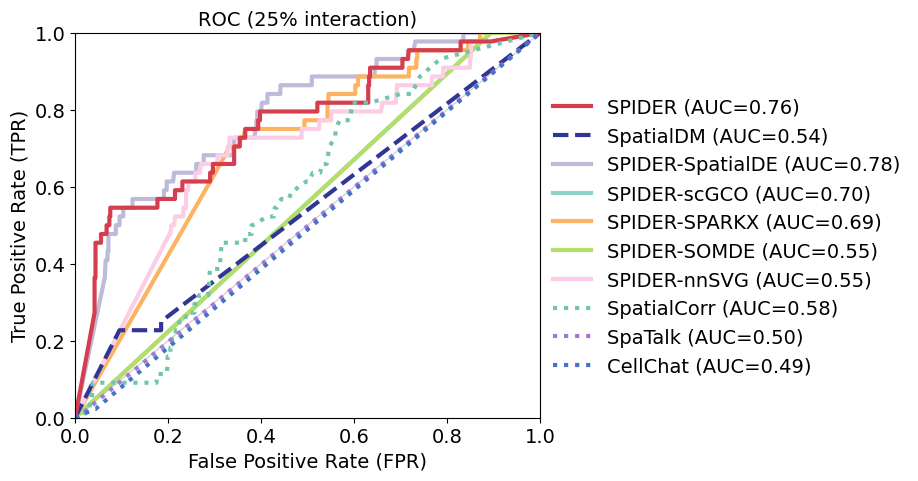

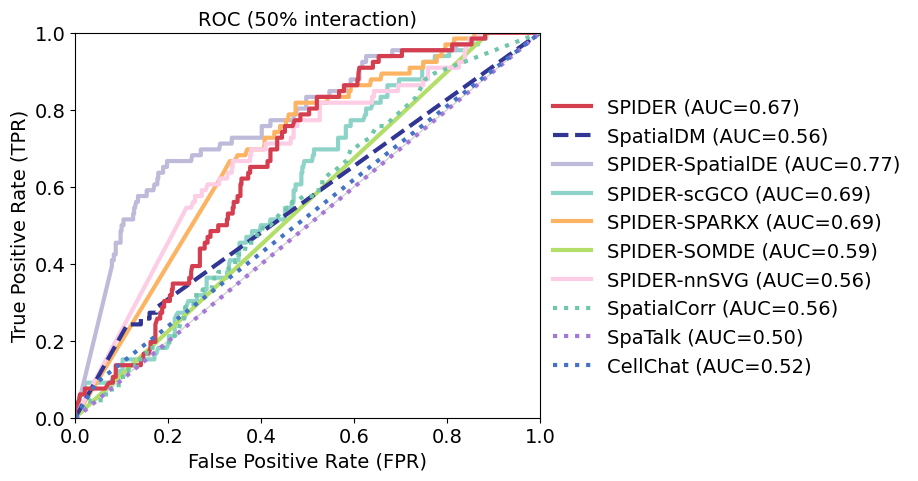

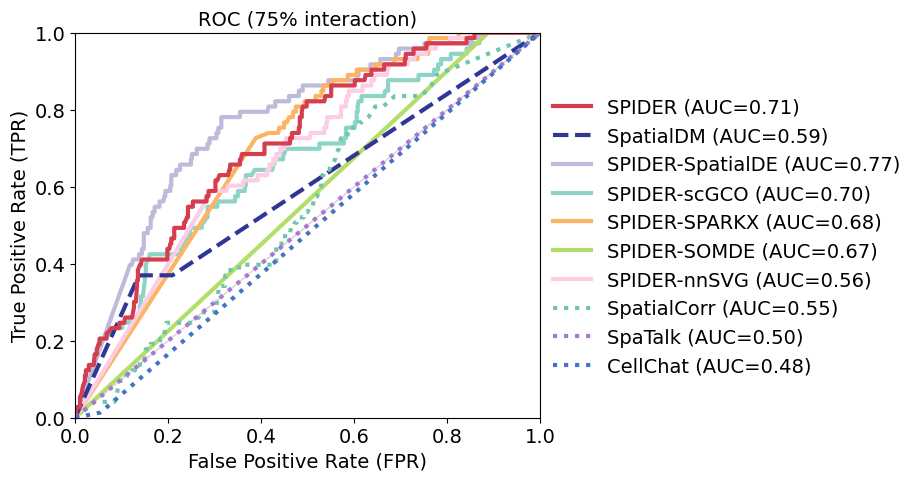

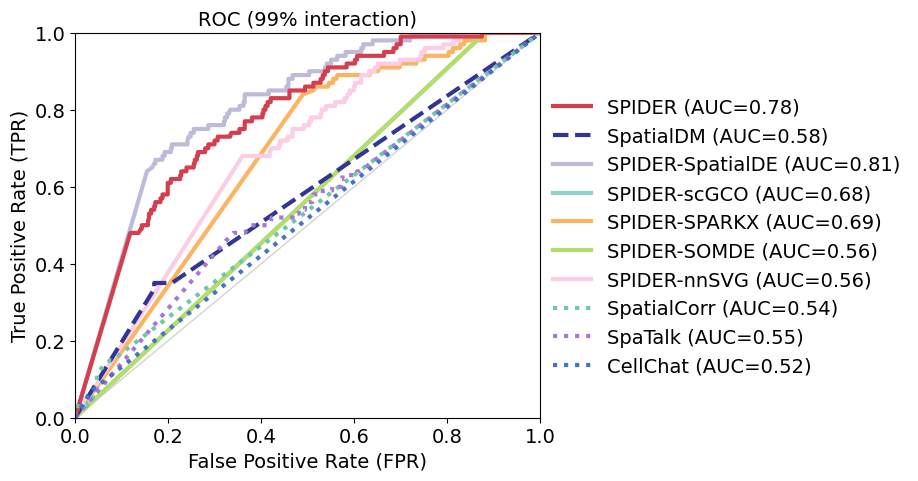

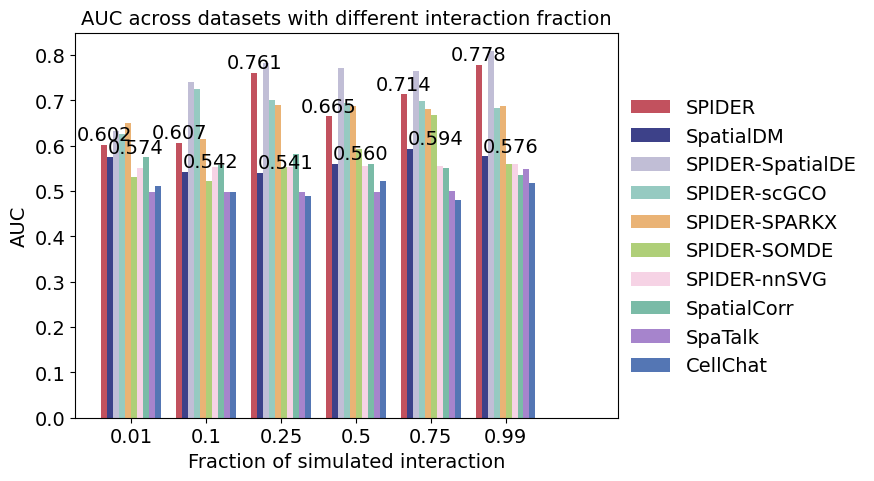

In [17]:
for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
    new_adata_99 = anndata.read_h5ad(f'./adata_{frac}.h5ad')
    lr_from_sv_name = var_exp_df[(var_exp_df['input_int_frac'] == frac)].gene.to_numpy()
    lr_from_nsv_name = var_exp_df_nsv[(var_exp_df_nsv['input_int_frac'] == frac)].gene.to_numpy()
    # for lr in both sv and nsv, drop nsv lrs
    lr_from_nsv_name = lr_from_nsv_name[~np.isin(lr_from_nsv_name, lr_from_sv_name)]
    sp = pd.read_csv(f'./spider_{frac}.csv', index_col=0)[['SOMDE', 'SpatialDE', 'SPARKX', 'nnSVG', 'scGCO']]
    sp['sp'] = sp.max(axis=1)

    dm = pd.read_csv(f'./spatialdm_{frac}.csv', index_col=0).drop_duplicates(subset=['Ligand0', 'Receptor0', 'Receptor1'])
    # dm = dm.drop_duplicates(subset=['Ligand0', 'Receptor0', 'Receptor1'])
    dm_expand = []
    addition = []
    for x in dm.to_numpy():
        l, r1, r2, _, fdr, _ = x
        if r2:
            addition.append([l, r1, fdr])
            addition.append([l, r2, fdr])
        else:
            dm_expand.append([l, r1, fdr])
    dm_expand = pd.DataFrame(dm_expand, columns=['ligand', 'receptor', 'fdr'])
    dm_expand.index = dm_expand['ligand'] + '_' + dm_expand['receptor']

    addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'fdr'])
    addition['lr'] = addition['ligand'] + '_' + addition['receptor']
    addition = addition.loc[addition.groupby('lr')['fdr'].idxmin()][['ligand', 'receptor', 'fdr']]
    addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                            
    dm_expand = pd.concat([dm_expand[['fdr']], addition[~addition.index.isin(dm_expand.index)][['fdr']]])

    spc = pd.read_csv(f'./spc_{frac}.csv', index_col=0)


    spatalk = pd.read_csv(f'./spatalk_{frac}.csv', index_col=0)

    if len(spatalk) != 0:
        spatalk.index = spatalk['ligand'] + '_' + spatalk['receptor']
        spatalk = spatalk.groupby(spatalk['ligand'] + '_' + spatalk['receptor'])['lr_co_ratio_pvalue'].min()
        
    cellchat = pd.read_csv(f'./cellchat_{frac}.csv', index_col=0)

    cellchat = cellchat.groupby(cellchat['ligand'] + '_' + cellchat['receptor'])['pval'].min().reset_index()
    cellchat[['Ligand0', 'Receptor0', 'Receptor1']] = cellchat['index'].str.split('_', expand=True).to_numpy()
    cellchat.set_index('index', inplace=True)
    dm_expand_cellchat = []
    addition = []
    for x in cellchat.to_numpy():
        fdr, l, r1, r2 = x
        if r2:
            addition.append([l, r1, fdr])
            addition.append([l, r2, fdr])
        else:
            dm_expand_cellchat.append([l, r1, fdr])
    dm_expand_cellchat = pd.DataFrame(dm_expand_cellchat, columns=['ligand', 'receptor', 'cellchat'])
    dm_expand_cellchat.index = dm_expand_cellchat['ligand'] + '_' + dm_expand_cellchat['receptor']

    addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'cellchat'])
    addition['lr'] = addition['ligand'] + '_' + addition['receptor']
    addition = addition.loc[addition.groupby('lr')['cellchat'].idxmin()][['ligand', 'receptor', 'cellchat']]
    addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                            
    dm_expand_cellchat = pd.concat([dm_expand_cellchat, addition[~addition.index.isin(dm_expand.index)]])

    if len(spatalk) != 0:
        merged = pd.concat([spc[['spc']], dm_expand, sp, spatalk, dm_expand_cellchat['cellchat']], axis=1).fillna(1)
    else:
        merged = pd.concat([spc[['spc']], dm_expand, sp, dm_expand_cellchat['cellchat']], axis=1).fillna(1)
        merged['lr_co_ratio_pvalue'] = 1
        
    assert len(np.unique(merged.index)) == len(merged)

    lrdf_index = (lr_df['ligand'] + '_' + lr_df['receptor']).to_numpy()

    true_label = []
    for x in merged.index:
        l, r = x.split('_')
        if l in new_adata_99.var_names and r in new_adata_99.var_names:
            if r in non_sv_r_genes.index:
                true_label.append(0)
            elif l in lr_from_nsv_name:
                true_label.append(0)
            elif x not in lrdf_index:
                true_label.append(-1)
            elif l == r:
                true_label.append(0)
            elif x not in lrdf_index:
                true_label.append(0)
            elif l in lr_from_sv_name:
                l_exp = new_adata_99.to_df()[l]
                r_exp = new_adata_99.to_df()[r]
                # get correlation bettwen l_exp and r_exp
                corr = np.corrcoef(l_exp, r_exp)[0, 1]
                if corr <= 0.1:
                    true_label.append(0)
                else:
                    df = var_exp_df.query(f'input_int_frac=={frac}')
                    true_label.append(df.loc[df.gene==l, 'label'].values[0])

            else:
                print(l, r)
                true_label.append(-1)
        else:
            true_label.append(-1)

    merged['label'] = true_label
    merged_sub = merged[merged['label'] != -1]

    arr_x = []
    arr_y = []
    # from sklearn.metrics import confusion_matrix
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    y_true = merged_sub['label']
    fpr_sp, tpr_sp, thresholds_sp = roc_curve(y_true, 1-merged_sub['sp'])
    fpr_SOMDE, tpr_SOMDE, thresholds_SOMDE = roc_curve(y_true, 1-merged_sub['SOMDE'])
    fpr_SpatialDE, tpr_SpatialDE, thresholds_SpatialDE = roc_curve(y_true, 1-merged_sub['SpatialDE'])
    fpr_scGCO, tpr_scGCO, thresholds_scGCOE = roc_curve(y_true, 1-merged_sub['scGCO'])
    fpr_nnSVG, tpr_nnSVG, thresholds_nnSVG = roc_curve(y_true, 1-merged_sub['nnSVG'])
    fpr_SPARKX, tpr_SPARKX, thresholds_SPARKX = roc_curve(y_true, 1-merged_sub['SPARKX'])
    fpr_dm, tpr_dm, thresholds_dm = roc_curve(y_true, 1-merged_sub['fdr'])
    fpr_spc, tpr_spc, thresholds_spc = roc_curve(y_true, 1-merged_sub['spc'])
    fpr_spatalk, tpr_spatalk, thresholds_spatalk = roc_curve(y_true, 1-merged_sub['lr_co_ratio_pvalue'])
    fpr_cellchat, tpr_cellchat, thresholds_cellchat = roc_curve(y_true, 1-merged_sub['cellchat'])
    roc_auc_SOMDE = auc(fpr_SOMDE, tpr_SOMDE)
    roc_auc_SpatialDE = auc(fpr_SpatialDE, tpr_SpatialDE)
    roc_auc_scGCO = auc(fpr_scGCO, tpr_scGCO)
    roc_auc_nnSVG = auc(fpr_nnSVG, tpr_nnSVG)
    roc_auc_SPARKX = auc(fpr_SPARKX, tpr_SPARKX)
    roc_auc_sp = auc(fpr_sp, tpr_sp)
    roc_auc_dm = auc(fpr_dm, tpr_dm)
    roc_auc_spc = auc(fpr_spc, tpr_spc)
    roc_auc_spatalk = auc(fpr_spatalk, tpr_spatalk)
    roc_auc_cellchat = auc(fpr_cellchat, tpr_cellchat)
    # print(roc_auc)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], color='lightgray', lw=1)
    # Plot the lines
    line1, = plt.plot(fpr_SOMDE, tpr_SOMDE, color='#8dd3c7', lw=3, label=f'SPIDER-SOMDE  (AUC = {roc_auc_SOMDE:.2f})')
    line2, = plt.plot(fpr_SpatialDE, tpr_SpatialDE, color='#BEBADA', lw=3, label=f'SPIDER-SpatialDE  (AUC = {roc_auc_SpatialDE:.2f})')
    line3, = plt.plot(fpr_scGCO, tpr_scGCO, color='#FDB462', lw=3, label=f'SPIDER-scGCO  (AUC = {roc_auc_scGCO:.2f})')
    line4, = plt.plot(fpr_nnSVG, tpr_nnSVG, color='#B3DE69', lw=3, label=f'SPIDER-nnSVG  (AUC = {roc_auc_nnSVG:.2f})')
    line5, = plt.plot(fpr_SPARKX, tpr_SPARKX, color='#FCCDE5', lw=3, label=f'SPIDER-SPARKX  (AUC = {roc_auc_SPARKX:.2f})')
    line6, = plt.plot(fpr_dm, tpr_dm, color='#313695', lw=3, label=f'SpatialDM (AUC = {roc_auc_dm:.2f})', linestyle='--')
    line7, = plt.plot(fpr_sp, tpr_sp, color='#D53E4F', lw=3, label=f'SPIDER (AUC = {roc_auc_sp:.2f})')
    line8, = plt.plot(fpr_spc, tpr_spc, color='#6FC6AB', lw=3, label=f'SpatialCorr (AUC = {roc_auc_spc:.2f})', linestyle=':')
    line9, = plt.plot(fpr_spatalk, tpr_spatalk, color='#A578D8', lw=3, label=f'SpaTalk (AUC = {roc_auc_spatalk:.2f})', linestyle=':')
    line10, = plt.plot(fpr_cellchat, tpr_cellchat, color='#4472C4', lw=3, label=f'CellChat (AUC = {roc_auc_cellchat:.2f})', linestyle=':')

    # Set the x and y limits
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # Set the x and y labels and the plot title
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title(f'ROC ({int(frac*100)}% interaction)', fontsize=14)

    # Create a custom legend with desired order and font size
    handles = [line7, line6, line2, line1, line3, line4, line5, line8, line9, line10]
    labels = [
        f'SPIDER (AUC={roc_auc_sp:.2f})',
        f'SpatialDM (AUC={roc_auc_dm:.2f})',
        f'SPIDER-SpatialDE (AUC={roc_auc_SpatialDE:.2f})',
        f'SPIDER-scGCO (AUC={roc_auc_scGCO:.2f})',
        f'SPIDER-SPARKX (AUC={roc_auc_SPARKX:.2f})',
        f'SPIDER-SOMDE (AUC={roc_auc_SOMDE:.2f})',
        f'SPIDER-nnSVG (AUC={roc_auc_nnSVG:.2f})',
        f'SpatialCorr (AUC={roc_auc_spc:.2f})',
        f'SpaTalk (AUC={roc_auc_spatalk:.2f})',
        f'CellChat (AUC={roc_auc_cellchat:.2f})'
    ]

    # plt.legend(handles, labels, loc='lower right', fontsize=8)
    plt.legend(handles, labels, bbox_to_anchor=(1.01, 0.85),  loc=2, borderaxespad=0., fontsize=14, frameon=False)

    dic_99 = {
        'SPIDER': roc_auc_sp,
        'SpatialDM': roc_auc_dm,
        'SPIDER-SpatialDE': roc_auc_SpatialDE,
        'SPIDER-scGCO': roc_auc_scGCO,
        'SPIDER-SPARKX': roc_auc_SPARKX,
        'SPIDER-nnSVG': roc_auc_nnSVG,
        'SPIDER-SOMDE': roc_auc_SOMDE,
        'SpatialCorr': roc_auc_spc,
        'SpaTalk': roc_auc_spatalk,
        'CellChat': roc_auc_cellchat
    }
    import json
    # save dic_99 with json
    with open(f'./dic_{frac}.json', 'w') as f:
        json.dump(dic_99, f)
        
df = {}
import json

for frac in [0.01, 0.1, 0.25, 0.5, 0.75, 0.99]:
    # read json ./dic_{frac}.json
    with open(f'./dic_{frac}.json', 'r') as f:
        dic = json.load(f)
    df[str(frac)] = dic
df = pd.DataFrame(df)
df = df.rename_axis('method').reset_index(drop=False).melt(id_vars='method')
df.columns = ['Method', 'Fraction of interaction', 'AUC']
import seaborn as sns
# code for plotting df with seaborn grouped bar plot
plt.figure(figsize=(7, 5))
g = sns.barplot(data=df, x='Fraction of interaction', y='AUC', hue='Method', 
            hue_order=['SPIDER', 'SpatialDM', 'SPIDER-SpatialDE', 'SPIDER-scGCO', 'SPIDER-SPARKX', 'SPIDER-SOMDE', 'SPIDER-nnSVG', 'SpatialCorr', 'SpaTalk', 'CellChat'],
            palette=['#D53E4F', '#313695', '#BEBADA', '#8dd3c7', '#FDB462','#B3DE69', '#FCCDE5', '#6FC6AB', '#A578D8', '#4472C4'],)
count = 0
for p in g.patches:
    if count < 6:
        if False:
        # if count < 2:
            g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. - 0.03, p.get_height()+0.02),
                ha='left', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
        else:
            g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. , p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
    elif count < 12:
        g.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2. - 0.03, p.get_height()),
                ha='left', va='center', xytext =(0, 7), textcoords='offset points', fontsize=14)
    count += 1
plt.xlim([-0.75, 6.5])
# plt.ylim([0.4, 0.85])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
plt.legend(bbox_to_anchor=(1.01, 0.85),  loc=2, borderaxespad=0., fontsize=14, frameon=False)
plt.ylabel('AUC', fontsize=14)
plt.xlabel('Fraction of simulated interaction', fontsize=14)
plt.title(f'AUC across datasets with different interaction fraction', fontsize=14)

